In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

# Clasificación

## Estudio preliminar de los datos

Lo primero que se va a hacer es importar los datos y hacer un breve estudio para ver con qué se va a trabajar

In [2]:
df = pd.read_csv('airbnb.csv')
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250


Con el método DataFrame.info() se puede ver si hay valores nulos en alguna columna

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             13321 non-null  object 
 1   neighbourhood                   13321 non-null  object 
 2   latitude                        13321 non-null  float64
 3   longitude                       13321 non-null  float64
 4   room_type                       13321 non-null  object 
 5   price                           13321 non-null  int64  
 6   minimum_nights                  13321 non-null  int64  
 7   number_of_reviews               13321 non-null  int64  
 8   reviews_per_month               13321 non-null  float64
 9   calculated_host_listings_count  13321 non-null  int64  
 10  availability_365                13321 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


Afortunadamente no hay datos nulos así que no hay que realizar limpieza en ese aspecto

Para echar un primer vistazo a las variables numéricas se va a usar DataFrame.describe() que proporciona distintos estadísticos como la media, la mediana etc de cada variable numérica

In [4]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000
mean,40.420730,-3.697268,69.171834,3.010885,22.986037,1.520329,7.605885,205.867202
std,0.020344,0.023832,103.721126,12.835619,38.406006,1.852367,19.619972,126.968961
min,40.331888,-3.863907,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.410090,-3.707856,31.000000,1.000000,1.000000,0.110000,1.000000,84.000000
50%,40.418731,-3.701602,53.000000,2.000000,7.000000,0.780000,2.000000,247.000000
75%,40.427997,-3.693818,80.000000,3.000000,28.000000,2.320000,4.000000,321.000000
max,40.562736,-3.526821,7700.000000,1125.000000,446.000000,17.210000,145.000000,365.000000


Se observa que las variables price, minimum_nights, number_of_reviews y calculated_host_listings_count tienen una enorme diferencia entre su media y su mediana, lo que indica que son variables muy sesgadas. Cuando a continuación se dibujen sus histogramas se observará una cola por la derecha

Ahora se va a estudiar las variables categóricas haciendo un recuento de cuantas veces aparece cada valor

In [5]:
df["neighbourhood_group"].value_counts()

Centro                   6773
Chamberí                  960
Salamanca                 883
Arganzuela                790
Tetuán                    463
Moncloa - Aravaca         450
Retiro                    439
Latina                    379
Chamartín                 361
Carabanchel               358
Ciudad Lineal             308
Puente de Vallecas        222
Hortaleza                 185
Fuencarral - El Pardo     170
Usera                     145
San Blas - Canillejas     117
Villaverde                 83
Barajas                    81
Moratalaz                  74
Villa de Vallecas          46
Vicálvaro                  34
Name: neighbourhood_group, dtype: int64

In [6]:
df["neighbourhood"].value_counts()

Embajadores       1848
Universidad       1363
Palacio           1084
Sol                942
Justicia           788
                  ... 
Rosas                4
Santa Eugenia        4
Cuatro Vientos       3
Orcasitas            2
El Pardo             1
Name: neighbourhood, Length: 126, dtype: int64

In [7]:
df["room_type"].value_counts()

Entire home/apt    7926
Private room       5203
Shared room         192
Name: room_type, dtype: int64

En la variable room_type hay un gran desequilibrio entre sus categorías: la categoría Shared room es mucho menos frecuente que las otras dos. Este se tendrá en cuenta al hacer la separación en test y training set y al diseñar los modelos.

Se dibujan histogramas de las variables numéricas

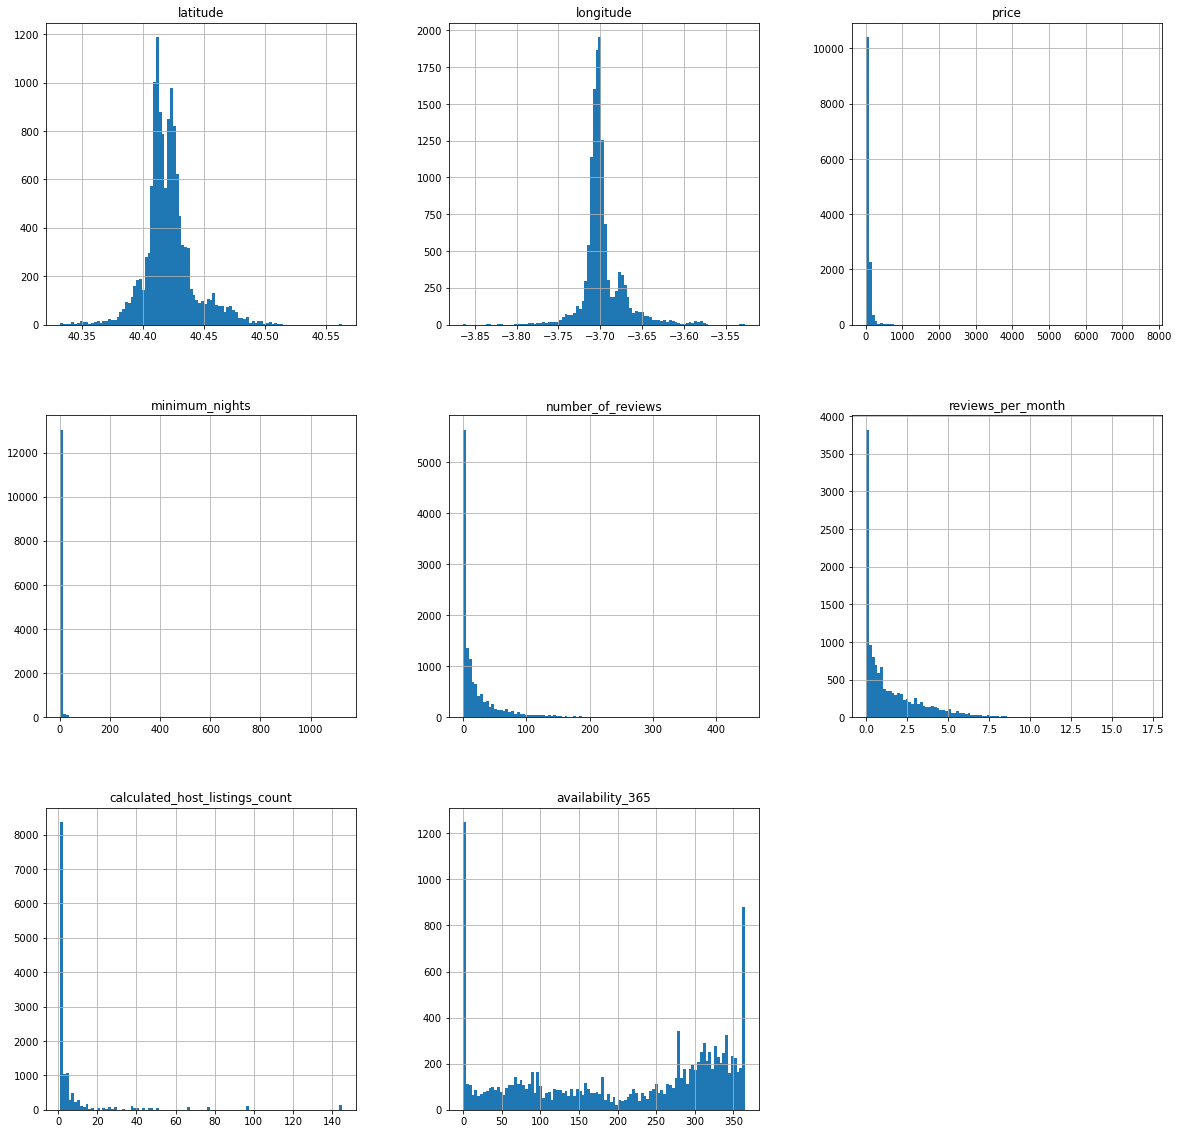

In [8]:
df.hist(bins=100,figsize=(20,20))
plt.show()

Como se esperaba, las variables price, minimum_nights, number_of_reviews y calculated_host_listings_count tienen su máximo muy a la izquierda y una cola por la derecha. Como los máximos son tan grandes hay valores que no se aprecian bien, así que a continuación se dibujan los mismos histogramas pero en escala logarítmica para que aprecien bien todos los valores

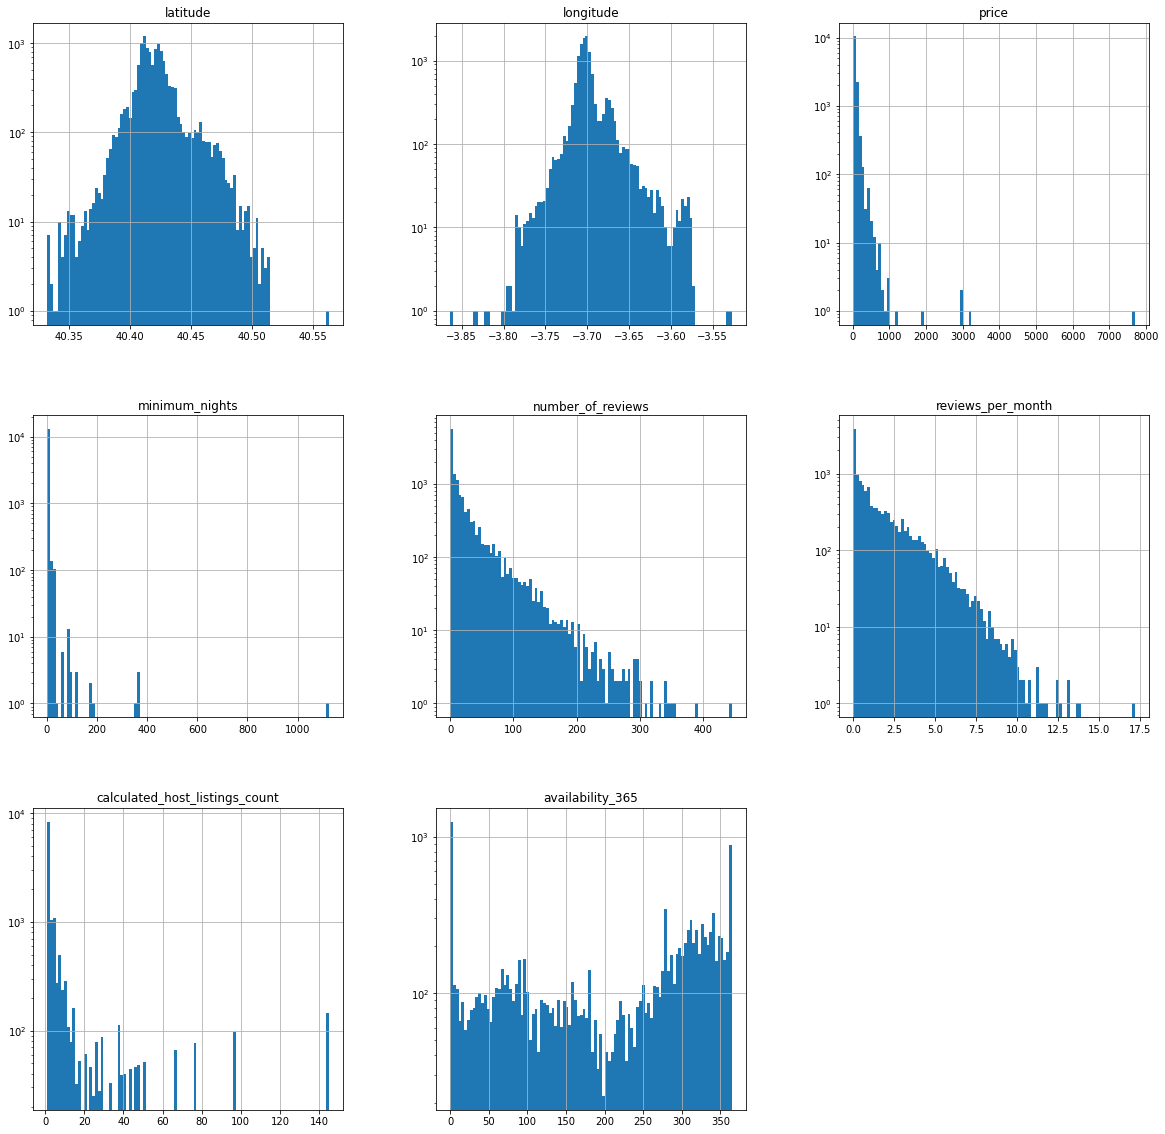

In [9]:
df.hist(bins=100,figsize=(20,20), log = True)
plt.show()

## Separación en training set y test set

Como la variable objetivo está tan desequilibrada, se va a usar StratifiedShuffleSplit para que la proporción entre las tres categorías de room_type se mantenga en ambos sets. 

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in split.split(df, df['room_type']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

A continuación se comprueba que la proporción entre las categorías en el test set es aproximadamente igual que en el dataframe original

In [11]:
test_set["room_type"].value_counts()/df["room_type"].value_counts()

Entire home/apt    0.200101
Private room       0.200077
Shared room        0.197917
Name: room_type, dtype: float64

## Preparación datos

La preparación de los datos va a consistir en solo dos transformaciones. A las variables numéricas se les va a aplicar StandarScaler de manera que tengan media 0 y desviación 1. A las variables categóricas se les aplica OneHotEncoder de manera que haya una columna con 1 o 0 para cada categoría. Estas transformaciones se realizan solo sobre las variables independientes, la variable independiente (room_type) queda intacta.

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

train_set_features = train_set.drop(columns=['room_type'])
train_set_labels = train_set['room_type'].copy()

num_attribs = ['latitude','longitude',
               'price','minimum_nights',
               'number_of_reviews',
               'reviews_per_month',
               'calculated_host_listings_count',
               'availability_365']
cat_attribs = ['neighbourhood_group', 'neighbourhood']

pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

train_set_prepared = pipeline.fit_transform(train_set_features)

También se realiza la preparación de los datos en el test set para luego poder comprobar la precisión del modelo sobre él.

In [13]:
test_set_features = test_set.drop(columns=['room_type'])
test_set_labels = test_set['room_type'].copy()

test_set_prepared = pipeline.transform(test_set_features)

### Linear SVC

Primero se usa el modelo de Linear SVC con los valores por defecto

In [14]:
from sklearn.svm import LinearSVC
linear_svc_clf = LinearSVC()

In [15]:
scores = cross_val_score(linear_svc_clf, train_set_prepared, train_set_labels,
                         scoring="accuracy", cv=10)
scores.mean()

C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.7908222568682891

(Nota: En distintos puntos del notebook sklearn me da warnings de que no converge y debo aumentar el número de iteraciones. He probado a aumentar el número de iteraciones hasta valores altísimos como 10 millones y me sigue dando el mismo warning, y además el score apenas cambia)

Para medir la precisión del modelo sobre el test set se ha creado una función que comparará las categorías predichas con las reales.

In [16]:
def accuracy(list1, list2):
    bool_list = (list1 == list2)
    return np.count_nonzero(bool_list == True)/len(bool_list)

In [17]:
linear_svc_clf.fit(train_set_prepared, train_set_labels)
predictions = linear_svc_clf.predict(test_set_prepared)
accuracy(predictions, test_set_labels.values)

0.7913696060037524

La exactitud en el test set es casi la misma que en el training set

In [18]:
np.unique(test_set_labels.values,return_counts=True)

(array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object),
 array([1586, 1041,   38], dtype=int64))

Se dibuja la matriz de confusión para ver en qué categorías se equivoca el modelo

In [19]:
confusion_matrix(test_set_labels.values, predictions)

array([[1417,  169,    0],
       [ 348,  691,    2],
       [   9,   28,    1]], dtype=int64)

Se observa que la mayoría de los 'Shared room' los clasifica mal (solo ha acertado en uno). También hay varios 'Private room' que etiqueta erróneamente como 'Entire home/apt'

### RBF SVC

In [20]:
from sklearn.svm import SVC
rbf_svc_clf = SVC(kernel="rbf")

Para el modelo SVC con kernel rbf se empieza optimizando los hiperparámetros C y gamma. Como a priori no se conoce en qué rango de valores están se empieza con una búsqueda muy amplia y después se va refinando.

In [24]:
param_grid = [
    {'C': np.logspace(-5, 15, num=11,base=2),
     'gamma':np.logspace(-15, 3, num=10,base=2)}]


grid_search = GridSearchCV(rbf_svc_clf, param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True,
                           n_jobs=-1,verbose=1)

grid_search.fit(train_set_prepared, train_set_labels)
grid_search.best_params_

Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed: 41.6min finished


{'C': 128.0, 'gamma': 0.03125}

En función de estos resultados se puede realizar una búsqueda con un grid más fino.

In [34]:
param_grid = [
    {'C': np.logspace(5, 9, num=13,base=2),
     'gamma':np.logspace(-7, -3, num=13,base=2)}]


grid_search = GridSearchCV(rbf_svc_clf, param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True,
                           n_jobs=-1, verbose=1)

grid_search.fit(train_set_prepared, train_set_labels)
grid_search.best_params_

Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed: 24.9min finished


{'C': 50.796833662982394, 'gamma': 0.049606282874006216}

'C': 16.0, 'gamma': 0.06750373368076912

Se hace una última búsqueda para encontrar los valores óptimos.

In [36]:
np.logspace(-7, -3, num=13,base=2)

array([0.0078125 , 0.00984313, 0.01240157, 0.015625  , 0.01968627,
       0.02480314, 0.03125   , 0.03937253, 0.04960628, 0.0625    ,
       0.07874507, 0.09921257, 0.125     ])

In [37]:
param_grid = [
    {'C': range(40,64),
     'gamma':[0.04,0.05,0.06]}]


grid_search = GridSearchCV(rbf_svc_clf, param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True,
                           n_jobs=-1,verbose=1)

grid_search.fit(train_set_prepared, train_set_labels)
grid_search.best_params_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  8.9min finished


{'C': 49, 'gamma': 0.05}

Ahora que se han encontrado los hiperparámetros óptimos se evalúa el modelo con cross validation.

In [38]:
rbf_svc_clf = SVC(kernel="rbf",C=49,gamma=0.05)
scores = cross_val_score(rbf_svc_clf, train_set_prepared, train_set_labels,
                         scoring="accuracy", cv=10)
scores.mean()

0.8963974843432074

También se evalúa el modelo usando el test set.

In [39]:
rbf_svc_clf.fit(train_set_prepared, train_set_labels)
predictions = rbf_svc_clf.predict(test_set_prepared)
accuracy(predictions, test_set_labels.values)

0.899437148217636

Tanto con cross validation como con el test set se observa que la exactitud de este modelo ha mejorado bastante con respecto al modelo lineal.

Se dibuja la matriz de confusión.

In [40]:
confusion_matrix(test_set_labels.values, predictions)

array([[1477,  109,    0],
       [ 117,  917,    7],
       [   6,   29,    3]], dtype=int64)

A diferencia de en el modelo lineal ahora hay menos confusión entre las categorías 'Entire home/apt' y 'Private room', pero la categoría 'Shared room' la sigue clasificando fatal.

# Regresión

Con esta regresión se pretende modelar la variable 'Price' a partir de todas las demás. Puesto que el problema es fundamentalmente distinto al de clasificación se parte de el dataframe original, sin usar las transformaciones que se hayan usado en la sección anterior.

## Eliminación outliers

Para identificar y eliminar los outliers se va a emplear el z-score, que mide a cuantas desviaciones típicas está una observación de la media. Se ha decidido eliminar outliers teniendo en cuenta solo el valor de la variable 'price', porque como es la variable objetivo, influye mucho más que las otras. Se han hecho pruebas quitando outliers de las variables 'minimum_nights' y 'calculated_host_listings_count', y se ha observado que a menos que se quite un gran número de observaciones el resultado no varía.

In [6]:
from scipy import stats

df_inliers = df.copy()
df_inliers= df_inliers[stats.zscore(df_inliers['price'])<1]

In [7]:
len(df_inliers.index)/len(df.index)*100

95.54838225358456

Escogiendo z-score < 1 solo se eliminan un 5% de las observaciones.

Ahora que se ha hecho una limpieza, se representan unos histogramas de 'price','minimum_nights' y 'calculated_host_listings_count', que son las variables con más outliers.

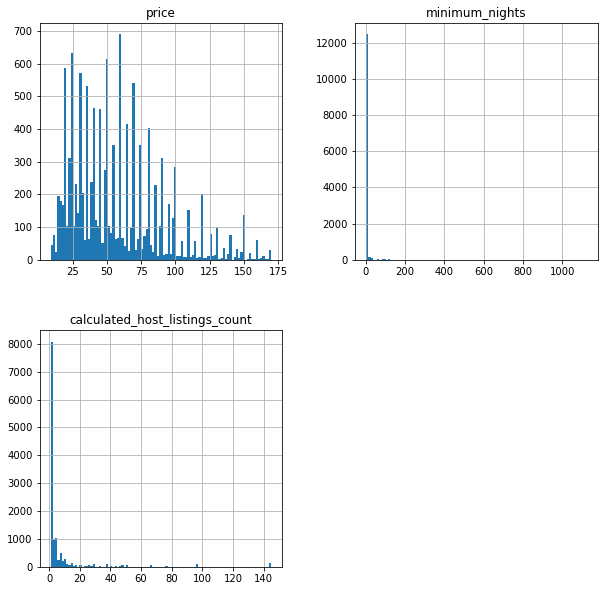

In [62]:
df_inliers[['price','minimum_nights','calculated_host_listings_count']].hist(bins=100,figsize=(10,10))
plt.show()

Viendo estos histogramas es tentador seguir quitando outliers, pues estas variables tienen trails muy largos por la derecha que van a empeorar la capacidad predictiva del modelo. Aún así se ha decidido dejarlo así porque para eliminar esos trails habría que eliminar un porcentaje muy alto del dataset (alrededor de un 30%)

### Separación en training y test set

Se separan los datos en train y test set

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_inliers, test_size=0.2, random_state=1)

### Preparación datos

Se realizan dos transformaciones: a los datos numéricos se les aplica StandarScaler y a los categóricos OneHotEncoder

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

train_set_features = train_set.drop(columns=['price'])
train_set_labels = train_set['price'].copy()

num_attribs = ['latitude','longitude',
               'minimum_nights',
               'number_of_reviews',
               'reviews_per_month',
               'calculated_host_listings_count',
               'availability_365']
cat_attribs = ['neighbourhood_group','room_type','neighbourhood']

pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
    ])

train_set_prepared = pipeline.fit_transform(train_set_features)

Al test set se le aplican las mismas transformaciones

In [10]:
test_set_features = test_set.drop(columns=['price'])
test_set_labels = test_set['price'].copy()

test_set_prepared = pipeline.transform(test_set_features)

### LinearSVR

Primero se prueba el modelo lineal con las opciones por defecto.

In [11]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR()

In [67]:
scores = cross_val_score(svm_reg, train_set_prepared, train_set_labels,
                         scoring="r2", cv=10)
R2 = scores.mean()
R2

0.4814187319518098

Para comparar este modelo que tiene todas las  variables con uno al que se le haya quitado la variable 'neighbourhood' se va a usar R2 ajustado, que disminuye al aumentar las variables.

In [68]:
def adjR2(R2,n,k):
    numerador = (1-R2)*(n-1)
    denominador = n-k-1
    return 1-(numerador/denominador)

In [69]:
n = train_set_prepared.shape[0] # Número de filas
k = train_set_prepared.shape[1] # Número de columnas

In [70]:
adjR2(R2,n,k)

0.4732964994015737

Si al dataset se le quita neighbourhood su R2 ajustado es 0.45690523741188493, que es peor que el del modelo con todas las variables, por lo que finalmente se deja la variable.

### SVR

Ahora se prueba SVR con las opciones por defecto.

In [71]:
from sklearn.svm import SVR

svm_poly_reg = SVR()

In [72]:
scores = cross_val_score(svm_poly_reg, train_set_prepared, train_set_labels,
                         scoring="r2", cv=10)
R2 = scores.mean()
R2

0.46059600831918984

El resultado es peor que el del modelo lineal.

### Ajuste Hiperparámetros

Como en la sección anterior se ha visto que el modelo lineal obtiene mejores resultados se va a optimizar el hiperparámetro C para este modelo. Primero se usa un grid amplio para ver en que rango de valores está el óptimo.

In [73]:
svm_reg = LinearSVR()
param_grid = [
    {'C': np.logspace(-5, 15, num=21,base=2)}]


grid_search = GridSearchCV(svm_reg, param_grid, cv=10,
                           scoring='r2',
                           return_train_score=True,n_jobs=-1)

grid_search.fit(train_set_prepared, train_set_labels)
grid_search.best_params_

{'C': 4.0}

Ahora se usa un grid más fino para encontrar el valor final.

In [75]:
svm_reg = LinearSVR()
param_grid = [{'C': range(2,16)}]


grid_search = GridSearchCV(svm_reg, param_grid, cv=10,
                           scoring='r2',
                           return_train_score=True, n_jobs=-1)

grid_search.fit(train_set_prepared, train_set_labels)
grid_search.best_params_

{'C': 5}

Una vez encontrado el valor óptimo de C se evalúa el modelo con cross validation.

In [17]:
svm_reg = LinearSVR(C=5)
scores = cross_val_score(svm_reg, train_set_prepared, train_set_labels,
                         scoring="r2", cv=10)
scores.mean()

0.4819145628218474

También se evalúa el modelo usando el test set.

In [77]:
svm_reg.fit(train_set_prepared, train_set_labels)
svm_reg.score(test_set_prepared,test_set_labels)

0.4851766835917376

Al ser una regresión multivariable no se puede representar la recta de regresión porque está en más de 3 dimensiones. En vez de eso, se representa un scatterplot con los valores del precio real frente a los valores predichos. Se ha dibujado sobre los puntos la recta y=x para servir como apoyo visual pero no representa nada.

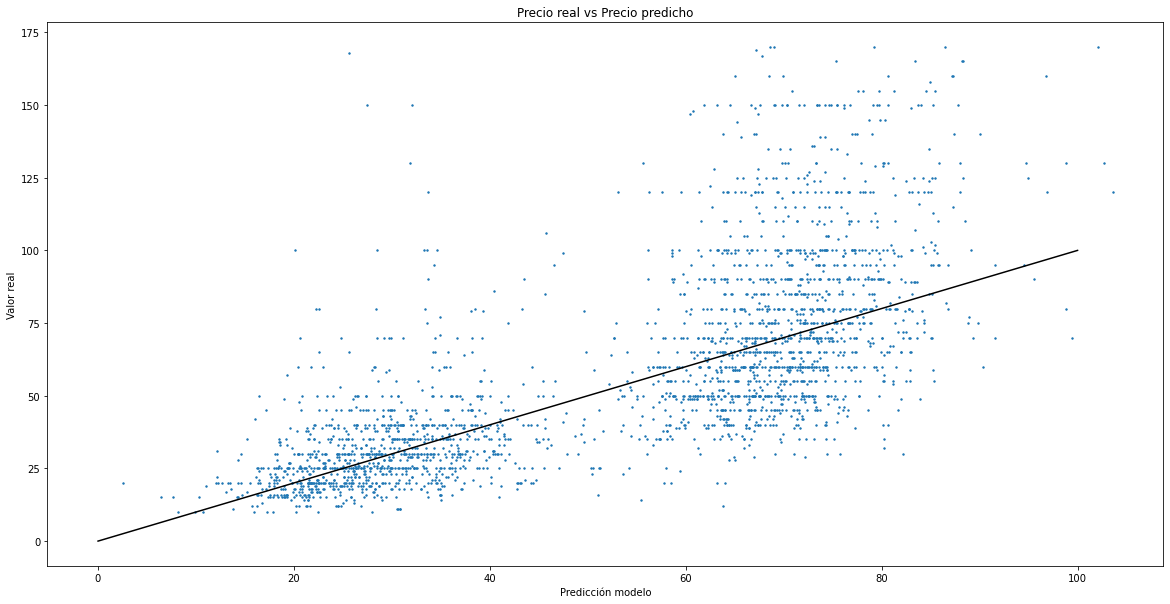

In [78]:
plt.figure(figsize=(20,10))
plt.plot([0,100], [0,100], c=[0,0,0])
plt.scatter(svm_reg.predict(test_set_prepared), test_set_labels, s = 2)
plt.xlabel("Predicción modelo")
plt.ylabel("Valor real")
plt.title("Precio real vs Precio predicho")
plt.show()

# Conclusiones

Para el ejercicio de clasificación se observa que usando un modelo lineal y con las opciones por defecto se consigue una exactitud considerable del 79%. Este modelo es incapaz de clasificar correctamente 'Shared room' y también clasifica erroneamente algunos 'Private room' como 'Entire home/apt'. 

Por otro lado, el modelo con kernel rbf y con los hiperparámetros optimizados consigue una exactitud mejor de casi el 90%. Este modelo es bastante mejor distinguiendo 'Private room' de 'Entire home/apt' que el lineal, pero sigue sin poder distinguir en absoluto los 'Shared room'. La dificualtad que tienen ambos modelos para clasificar 'Shared room' se debe probablemente a que hay menos datos de esta clase.

En cuanto al ejercicio de regresión, se ha visto que el modelo con kernel lineal obtiene mejores resultados que el modelo con kernel rbf, aunque en realidad la diferencia entre sus r2 es pequeña (un 0.48 frente a un 0.46). También se ha observado que ajustar el hiperparámetro C apenas mejora el modelo con respecto al valor por defecto. 

Tanto por el valor de r2 como por la gráfica anterior se puede ver que el modelo de regresión no es muy bueno. Esto se debe probablemente a que las variables numéricas del dataset tienen mucha varianza, sobre todo 'price', 'minimum_nights' y 'calculated_host_listings_count'.